# The Battle of Neighborhoods - Final Project

## 1.) Installing Packages

In [1]:
!conda install -c conda-forge folium --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge wordcloud==1.4.1 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

## 2.) Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func
print('Libraries imported')

Libraries imported


## 3.) Loading data of New York and Toronto Neighborhoods

* [New York Neighborhoods](https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json)
* [Toronto Neighborhoods](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

### 3.1.) New York Neighborhood data

#### Downloading and loading JSON data

In [3]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Downloading successful')

with open('newyork_data.json') as new_york_json_data:
    data_new_york = json.load(new_york_json_data)

print('Loading successful')

Loading successful


#### Create dataframe and examine data

In [4]:
neighborhoods_new_york = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in data_new_york['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_new_york = neighborhoods_new_york.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Only taking Neighborhoods from Manhattan
neighborhoods_new_york = neighborhoods_new_york[neighborhoods_new_york['Borough'] == 'Manhattan'].reset_index(drop = True)
neighborhoods_new_york.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [5]:
print('Shape of neighborhoods_new_york dataframe: {}'.format(neighborhoods_new_york.shape))

Shape of neighborhoods_new_york dataframe: (40, 4)


### 3.2.) Toronto Neighborhood data

#### Downloading and loading data from Wikipedia

In [6]:
wikipage = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
print('Downloading successful')
html = wikipage.text
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]
print('Loading successful')

Loading successful


#### Create dataframe and examine data

In [7]:
Toronto_table = pd.read_html(htmlTable, header = 0)[0]
Toronto_table["Borough"] = Toronto_table["Borough"].replace({"Not assigned":np.nan})                
Toronto_table.dropna(inplace = True)                                                          
Toronto_table.where(Toronto_table != "Not assigned", Toronto_table["Borough"], axis = 0, inplace = True) 
Toronto_table.rename(index=str, columns={"Postal Code":"Postal code"},inplace = True)
joinedRows = Toronto_table.groupby("Postal code")["Neighborhood"].apply(lambda x: ", ".join(x)) 
Toronto_table.drop_duplicates(["Postal code"],inplace = True)                                    
df_Toronto = Toronto_table.join(joinedRows, on = "Postal code", lsuffix='_single')                       
df_Toronto.drop(columns = ["Neighborhood_single"], inplace = True)                         
df_Toronto.reset_index(drop = True, inplace = True)

In [8]:
Toronto_table.rename(index=str, columns={"Postalcode":"Postal code"},inplace = True)
Toronto_table.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


#### Adding latitude and longitude using [http://cocl.us/Geospatial_data](http://cocl.us/Geospatial_data)

In [9]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_toronto = df_Toronto.join(geo, on = "Postal code")

# Only taking Neighborhoods from Toronto
neighborhoods_toronto = neighborhoods_toronto[neighborhoods_toronto['Borough'].str.contains('Toronto')].reset_index(drop = True)
neighborhoods_toronto.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
2,M5B,Downtown Toronto,Garden District / Ryerson,43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [10]:
print('Shape of neighborhoods_toronto dataframe: {}'.format(neighborhoods_toronto.shape))

Shape of neighborhoods_toronto dataframe: (39, 5)


### 3.3.) Visualizing the neighborhoods of New York and Toronto

#### Getting coordiantes of New York and Toronto and find center between them

In [11]:
address_new_york = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location_new_york = geolocator.geocode(address_new_york)
latitude_new_york = location_new_york.latitude
longitude_new_york = location_new_york.longitude
print('The coordinates of New York, Manhattan are {}, {}.'.format(latitude_new_york, longitude_new_york))

address_toronto = 'Toronto'

location_toronto = geolocator.geocode(address_toronto)
latitude_toronto = location_toronto.latitude
longitude_toronto = location_toronto.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

centerLatitude = (latitude_new_york + latitude_toronto)/2
centerLongitude = (longitude_new_york + longitude_toronto)/2

print('The center between New York, Manahttan and Toronto has the coordinates {}, {}.'.format(centerLatitude, centerLongitude))

The coordinates of New York, Manhattan are 40.7896239, -73.9598939.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.
The center between New York, Manahttan and Toronto has the coordinates 42.2215528, -76.6719143.


#### Connecting the tables of New York and Toronto for Visualization in one Map

In [12]:
tmp_neighborhoods_toronto = neighborhoods_toronto.drop("Postal code",axis = 1)
df_new_york_toronto = neighborhoods_new_york.append(tmp_neighborhoods_toronto, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
print('Shape of df_new_york_toronto dataframe {}'.format(df_new_york_toronto.shape))
df_new_york_toronto.head()

Shape of df_new_york_toronto dataframe (79, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### Visualizing the Neighborhoods of New York and Toronto in one Map with Folium

In [13]:
map_new_york_toronto = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df_new_york_toronto['Latitude'], df_new_york_toronto['Longitude'], df_new_york_toronto['Borough'], df_new_york_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york_toronto)
map_new_york_toronto

#### Map New York, Manhattan Neighborhoods

In [14]:
map_new_york_toronto = folium.Map(location=[latitude_new_york, longitude_new_york], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df_new_york_toronto['Latitude'], df_new_york_toronto['Longitude'], df_new_york_toronto['Borough'], df_new_york_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york_toronto)

minimap_new_york = MiniMap(position = 'bottomleft', center_fixed = (latitude_new_york, longitude_new_york), zoom_level_fixed = 8)
minimap_new_york.add_to(map_new_york_toronto)

minimap_toronto = MiniMap(position='bottomright',  center_fixed = (latitude_toronto, longitude_toronto), zoom_level_fixed = 8)
minimap_toronto.add_to(map_new_york_toronto)
map_new_york_toronto

#### Map Toronto Neighborhoods

In [15]:
map_new_york_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df_new_york_toronto['Latitude'], df_new_york_toronto['Longitude'], df_new_york_toronto['Borough'], df_new_york_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york_toronto)

minimap_new_york = MiniMap(position = 'bottomleft', center_fixed = (latitude_new_york, longitude_new_york), zoom_level_fixed = 8)
minimap_new_york.add_to(map_new_york_toronto)

minimap_toronto = MiniMap(position='bottomright',  center_fixed = (latitude_toronto, longitude_toronto), zoom_level_fixed = 8)
minimap_toronto.add_to(map_new_york_toronto)
map_new_york_toronto

## 4.) Importing data from Foursquare

### 4.1.) Entering Foursquare Credentials

In [16]:
CLIENT_ID = 'GXMUTI4TB5VBMTZ114YHYHECMHQ2KHEJLU3BBAX0INHW3AHP' # your Foursquare ID
CLIENT_SECRET = 'PJFI3SRZXIPNSHW4IKRBYQYFHT5UR4C4VCHODYJ4YTJQUQYB' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100

### 4.2.) Preparation for the GET request and sending of it

In [17]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
venues_new_york_toronto = getNearbyVenues(names=df_new_york_toronto['Neighborhood'],
                                   boroughs = df_new_york_toronto['Borough'],
                                   latitudes=df_new_york_toronto['Latitude'],
                                   longitudes=df_new_york_toronto['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Regent Park / Harbourfront
42 | Queen's Park / Ontario Provincial Government
43 | Garden District / Ryerson
44 | St. James Town
45 | The Beaches
46 | Berczy Park
47 | Central Bay Street
48 | Christie
49 | Richmond / Adelaide / King
50 | Dufferin / Dovercourt Village
51 | Harbourfront Eas

### 4.3) One Hot encoding and grouping by neighborhoods

In [19]:
# one hot encoding
onehot_new_york_toronto = pd.get_dummies(venues_new_york_toronto[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_new_york_toronto['Neighborhood'] = venues_new_york_toronto['Neighborhood'] 
onehot_new_york_toronto['Borough'] = venues_new_york_toronto['Borough']
onehot_new_york_toronto['Neighborhood Latitude'] = venues_new_york_toronto['Neighborhood Latitude']
onehot_new_york_toronto['Neighborhood Longitude'] = venues_new_york_toronto['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [onehot_new_york_toronto.columns[-1]] + list(onehot_new_york_toronto.columns[:-1])
onehot_new_york_toronto = onehot_new_york_toronto[fixed_columns]

grouped_new_york_toronto = onehot_new_york_toronto.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()
  
grouped_new_york_toronto

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.016667,0.033333,0.00,0.000000,0.000000
1,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000
2,Brockton / Parkdale Village / Exhibition Place,West Toronto,43.636847,-79.428191,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Washington Heights,Manhattan,40.851903,-73.936900,0.010989,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.010989,0.021978,0.00,0.010989,0.000000
77,West Village,Manhattan,40.734434,-74.006180,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.080000,0.010000,0.00,0.000000,0.000000
78,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.010000,0.030000,0.01,0.000000,0.000000


## 5.) Clustering

### 5.1.) Using the K-means algorithm for finding the centroids of the Clusters

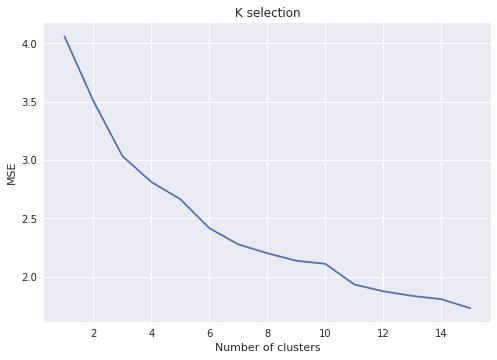

In [20]:
# Finding best k
plt.style.use("seaborn")
Ks = 16
MSE = np.zeros((Ks-1))
grouped_new_york_toronto_clustering = grouped_new_york_toronto.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=4, init = 'random', n_init = 25).fit(grouped_new_york_toronto_clustering)
    MSE[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),MSE)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

Following the elbow method, five clusters should be suitable for finding similiarities

In [21]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4, init = 'random', n_init = 25).fit(grouped_new_york_toronto_clustering)
    
merged_new_york_toronto = df_new_york_toronto

# add clustering labels
merged_new_york_toronto['Cluster Labels'] = kmeans.labels_

merged_new_york_toronto

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,4
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,2
...,...,...,...,...,...
76,Downtown Toronto,First Canadian Place / Underground city,43.648429,-79.382280,4
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,4
78,East Toronto,Business reply mail Processing Centre,43.662744,-79.321558,2


### 5.2) Displaying of Clusters in Maps

In [22]:
map_clusters_new_york_toronto = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_new_york_toronto['Latitude'], merged_new_york_toronto['Longitude'], merged_new_york_toronto['Neighborhood'], merged_new_york_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_new_york_toronto)
       
map_clusters_new_york_toronto

In [23]:
map_clusters_new_york = folium.Map(location=[latitude_new_york, longitude_new_york], zoom_start=12, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_new_york_toronto['Latitude'], merged_new_york_toronto['Longitude'], merged_new_york_toronto['Neighborhood'], merged_new_york_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_new_york)
       
minimap_new_york = MiniMap(position = 'bottomleft', center_fixed = (latitude_new_york, longitude_new_york), zoom_level_fixed = 8)
minimap_new_york.add_to(map_clusters_new_york)

minimap_toronto = MiniMap(position='bottomright',  center_fixed = (latitude_toronto, longitude_toronto), zoom_level_fixed = 8)
minimap_toronto.add_to(map_clusters_new_york)
        
map_clusters_new_york

In [24]:
map_clusters_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=12, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_new_york_toronto['Latitude'], merged_new_york_toronto['Longitude'], merged_new_york_toronto['Neighborhood'], merged_new_york_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
       
minimap_new_york = MiniMap(position = 'bottomleft', center_fixed = (latitude_new_york, longitude_new_york), zoom_level_fixed = 8)
minimap_new_york.add_to(map_clusters_toronto)

minimap_toronto = MiniMap(position='bottomright',  center_fixed = (latitude_toronto, longitude_toronto), zoom_level_fixed = 8)
minimap_toronto.add_to(map_clusters_toronto)
        
map_clusters_toronto

### 5.3.) Analyzing the Clusters

#### Cluster 1

In [25]:
cluster_01 = merged_new_york_toronto.loc[merged_new_york_toronto['Cluster Labels'] == 0, merged_new_york_toronto.columns[[1] + list(range(5, merged_new_york_toronto.shape[1]))]]
cluster_01

,Neighborhood
23,Soho
55,India Bazaar / The Beaches West


#### Cluster 2

In [26]:
cluster_02 = merged_new_york_toronto.loc[merged_new_york_toronto['Cluster Labels'] == 1, merged_new_york_toronto.columns[[1] + list(range(5, merged_new_york_toronto.shape[1]))]]
cluster_02

,Neighborhood
45,Berczy Park


#### Cluster 3

In [27]:
cluster_03 = merged_new_york_toronto.loc[merged_new_york_toronto['Cluster Labels'] == 2, merged_new_york_toronto.columns[[1] + list(range(5, merged_new_york_toronto.shape[1]))]]
cluster_03

,Neighborhood
1,Chinatown
2,Washington Heights
5,Manhattanville
...,...
69,Moore Park / Summerhill East
73,Rosedale
78,Business reply mail Processing Centre


#### Cluster 4

In [28]:
cluster_04 = merged_new_york_toronto.loc[merged_new_york_toronto['Cluster Labels'] == 3, merged_new_york_toronto.columns[[1] + list(range(5, merged_new_york_toronto.shape[1]))]]
cluster_04

,Neighborhood
34,Sutton Place


#### Cluster 5

In [29]:
cluster_05 = merged_new_york_toronto.loc[merged_new_york_toronto['Cluster Labels'] == 4, merged_new_york_toronto.columns[[1] + list(range(5, merged_new_york_toronto.shape[1]))]]
cluster_05

,Neighborhood
0,Marble Hill
3,Inwood
4,Hamilton Heights
...,...
75,St. James Town / Cabbagetown
76,First Canadian Place / Underground city
77,Church and Wellesley


## 6.) Visualization of data

### 6.1) Viualization using a Waffle Chart

In [30]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 400
Cluster 1: 10
Cluster 2: 5
Cluster 3: 172
Cluster 4: 5
Cluster 5: 208


<Figure size 576x396 with 0 Axes>

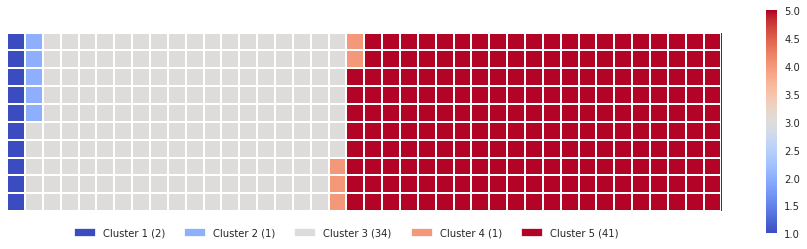

In [31]:
index = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5']
portions = [cluster_01.shape[0], cluster_02.shape[0], cluster_03.shape[0], cluster_04.shape[0], cluster_05.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

### 6.2.) Viualization using a Word Cloud

In [32]:
word_string = ""
for neighborhood in merged_new_york_toronto["Neighborhood"]:
    elements = ""
    for element in neighborhood.split(","):
        elements += element.strip().replace(" ", "") + " "
    word_string += elements+" "
word_string = word_string.replace(".","")

tmp_word_new_york_toronto_cluster_01 = cluster_01["Neighborhood"].tolist()
cluster_01_list = []
for element in tmp_word_new_york_toronto_cluster_01:
    cluster_01_list.extend(element.split(", "))
cluster_01_list = [element.replace(" ","") for element in cluster_01_list]

tmp_word_new_york_toronto_cluster_02 = cluster_02["Neighborhood"].tolist()
cluster_02_list = []
for element in tmp_word_new_york_toronto_cluster_02:
    cluster_02_list.extend(element.split(", "))
cluster_02_list = [element.replace(" ","") for element in cluster_02_list]

tmp_word_new_york_toronto_cluster_03 = cluster_03["Neighborhood"].tolist()
cluster_03_list = []
for element in tmp_word_new_york_toronto_cluster_03:
    cluster_03_list.extend(element.split(", "))
cluster_03_list = [element.replace(" ","") for element in cluster_03_list]

tmp_word_new_york_toronto_cluster_04 = cluster_04["Neighborhood"].tolist()
cluster_04_list = []
for element in tmp_word_new_york_toronto_cluster_04:
    cluster_04_list.extend(element.split(", "))
cluster_04_list = [element.replace(" ","") for element in cluster_04_list]

tmp_word_new_york_toronto_cluster_05 = cluster_05["Neighborhood"].tolist()
cluster_05_list = []
for element in tmp_word_new_york_toronto_cluster_05:
    cluster_05_list.extend(element.split(", "))
cluster_05_list = [element.replace(" ","") for element in cluster_05_list]

print('Cluster 1 venues:' + str(cluster_01_list))
print('Cluster 2 venues:' + str(cluster_02_list)) 
print('Cluster 3 venues:' + str(cluster_03_list)) 
print('Cluster 4 venues:' + str(cluster_04_list)) 
print('Cluster 5 venues:' + str(cluster_05_list)) 

Cluster 1 venues:['Soho', 'IndiaBazaar/TheBeachesWest']
Cluster 2 venues:['BerczyPark']
Cluster 3 venues:['Chinatown', 'WashingtonHeights', 'Manhattanville', 'CentralHarlem', 'RooseveltIsland', 'Clinton', 'Midtown', 'LowerEastSide', 'Tribeca', 'WestVillage', 'Gramercy', 'BatteryParkCity', 'MidtownSouth', "Queen'sPark/OntarioProvincialGovernment", 'GardenDistrict/Ryerson', 'St.JamesTown', 'CentralBayStreet', 'Christie', 'Dufferin/DovercourtVillage', 'HarbourfrontEast/UnionStation/TorontoIslands', 'LittlePortugal/Trinity', 'TheDanforthWest/Riverdale', 'TorontoDominionCentre/DesignExchange', 'StudioDistrict', 'Roselawn', 'DavisvilleNorth', 'ForestHillNorth&West', 'HighPark/TheJunctionSouth', 'TheAnnex/NorthMidtown/Yorkville', 'Davisville', 'UniversityofToronto/Harbord', 'MoorePark/SummerhillEast', 'Rosedale', 'BusinessreplymailProcessingCentre']
Cluster 4 venues:['SuttonPlace']
Cluster 5 venues:['MarbleHill', 'Inwood', 'HamiltonHeights', 'EastHarlem', 'UpperEastSide', 'Yorkville', 'LenoxH

Word cloud created!


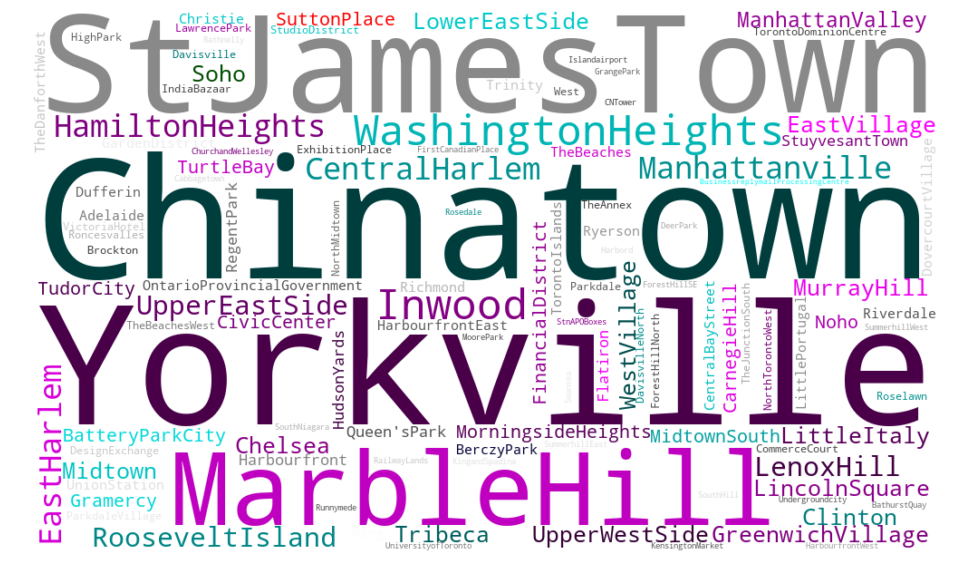

In [33]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words = 500).generate(word_string)

color_to_words = {
    # words below will be colored with a green single color function
    'green': cluster_01_list,
    # will be colored with a red single color function
    'blue': cluster_02_list,
    'cyan': cluster_03_list,
    'red': cluster_04_list,
    'magenta': cluster_05_list
}

default_color = 'grey'

print('Word cloud created!')

fig = plt.figure()
fig.set_figwidth(500)
fig.set_figheight(10)

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.show()

### 6.3.) Viualization using a Bar Chart

In [34]:
tmp_bar_chart = np.zeros((kmeans.cluster_centers_.shape))
tmp_bar_chart[0,:] = kmeans.cluster_centers_[4,:]
tmp_bar_chart[1,:] = kmeans.cluster_centers_[0,:]
tmp_bar_chart[2,:] = kmeans.cluster_centers_[3,:]
tmp_bar_chart[3,:] = kmeans.cluster_centers_[1,:]
tmp_bar_chart[4,:] = kmeans.cluster_centers_[2,:]

maxi = []
for i in range(5):
    maxi.extend(tmp_bar_chart[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table_bar_chart = pd.DataFrame(data = tmp_bar_chart[:,args.astype(int)], index = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5'], columns = grouped_new_york_toronto_clustering.columns[args.astype(int)])
table_bar_chart = table_bar_chart.transpose()

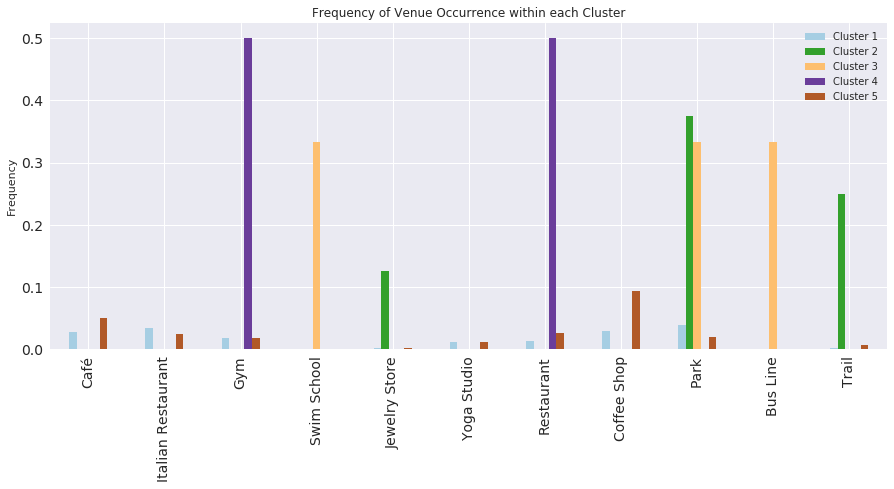

In [35]:
plt.style.use('seaborn')
ax = table_bar_chart.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Venue Occurrence within each Cluster")
plt.ylabel("Frequency")

plt.show()